In [1]:
!pip install -q seaborn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.3.0


In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)
raw_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [4]:
dataset=raw_dataset.copy()
dataset.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
dataset=dataset.dropna()
dataset.Origin=dataset.Origin.map({1:'US',2:'EU',3:'Japan'})
dataset=pd.get_dummies(dataset)
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_EU,Origin_Japan,Origin_US
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


In [16]:
X=dataset.copy()
y=X.pop('MPG')
X_train,X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=11)
train_dataset=pd.merge(y_train,X_train, left_index=True, right_index=True)
test_dataset=pd.merge(y_test,X_test, left_index=True, right_index=True)

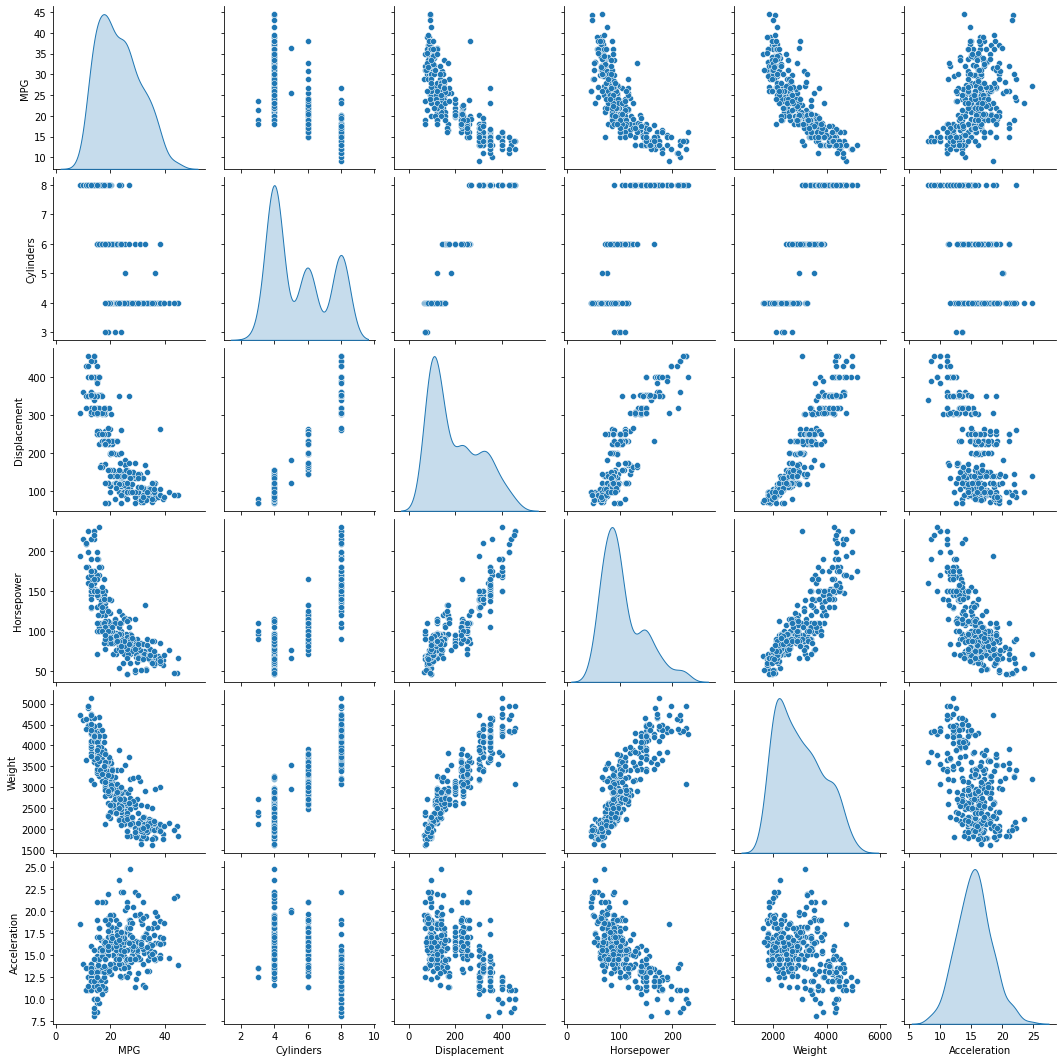

In [18]:
sns.pairplot(train_dataset[['MPG','Cylinders','Displacement','Horsepower', 'Weight', 'Acceleration']], diag_kind='kde')

In [19]:
train_dataset.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_EU,Origin_Japan,Origin_US
count,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000
mean,23.132588,5.520767,197.969649,105.699681,2988.811502,15.438339,75.776358,0.162939,0.201278,0.635783
std,7.654701,1.707933,106.797060,39.971375,852.835771,2.814352,3.666526,0.369902,0.401597,0.481981
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.000000,4.000000,105.000000,76.000000,2230.000000,13.500000,73.000000,0.000000,0.000000,0.000000
50%,22.000000,5.000000,151.000000,95.000000,2868.000000,15.500000,76.000000,0.000000,0.000000,1.000000
75%,28.100000,8.000000,302.000000,130.000000,3613.000000,17.000000,79.000000,0.000000,0.000000,1.000000
max,44.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


In [30]:
# Normalization layer
normalizer=preprocessing.Normalization()
normalizer.adapt(np.array(X_train))
print(normalizer.mean.numpy())
print(normalizer.variance.numpy())


[5.52076674e+00 1.97969650e+02 1.05699684e+02 2.98881152e+03
 1.54383383e+01 7.57763596e+01 1.62939295e-01 2.01277956e-01
 6.35782719e-01]
[2.9077158e+00 1.1369173e+04 1.5926063e+03 7.2500512e+05 7.8952713e+00
 1.3400463e+01 1.3639009e-01 1.6076514e-01 2.3156305e-01]


In [31]:
print(np.array(X_train[:1]))
print(normalizer(np.array(X_train[:1])).numpy())

[[8.000e+00 3.400e+02 1.600e+02 3.609e+03 8.000e+00 7.000e+01 0.000e+00
  0.000e+00 1.000e+00]]
[[ 1.4539231   1.3320384   1.3606554   0.72837186 -2.6472347  -1.5779539
  -0.44119886 -0.50199604  0.7568781 ]]


In [44]:
# Regression
%%time
linear_model=tf.keras.Sequential([
     normalizer,
     layers.Dense(units=1)
    ])

linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error')

training=linear_model.fit(
    X_train, y,
    epochs=100, verbose=0, validation_split=0.2)

CPU times: user 2.45 s, sys: 140 ms, total: 2.59 s
Wall time: 2.29 s


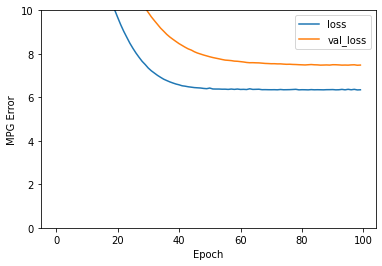

In [50]:
#plot loss
plt.plot(np.sqrt(training.history['loss']), label='loss')
plt.plot(np.sqrt(training.history['val_loss']), label='val_loss')
plt.ylim([0,10])
plt.ylabel('MPG Error')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [52]:
# DNN regression
def build_and_compile_model(norm):
  model=keras.Sequential([
                          norm,
                          layers.Dense(64, activation ='relu'),
                          layers.Dense(64, activation ='relu'),
                          layers.Dense(1)
                          ])
  model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [53]:
dnn_model=build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 9)                 19        
_________________________________________________________________
dense_7 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [54]:
%%time
history=dnn_model.fit(
    X_train, y_train,
    validation_split=0.2, verbose=0, epochs=100)

CPU times: user 2.86 s, sys: 163 ms, total: 3.03 s
Wall time: 2.62 s


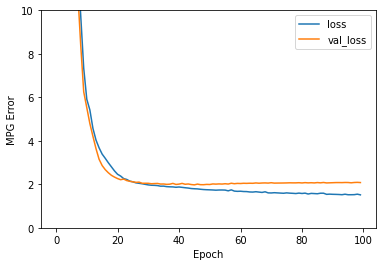

In [55]:
#plot loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0,10])
plt.ylabel('MPG Error')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [57]:
dnn_model_error=dnn_model.evaluate(X_test, y_test, verbose=0)
dnn_model_error

1.9583052396774292

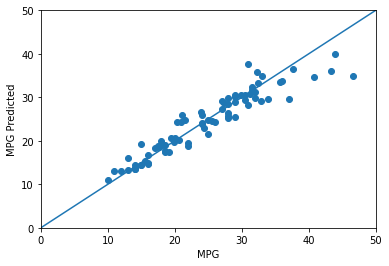

In [59]:
# Prediction
y_test_pred=dnn_model.predict(X_test).flatten()
plt.scatter(y_test, y_test_pred)
plt.xlabel('MPG')
plt.ylabel('MPG Predicted')
lims=[0, 50]
plt.xlim(lims)
plt.ylim(lims)
_=plt.plot(lims, lims)

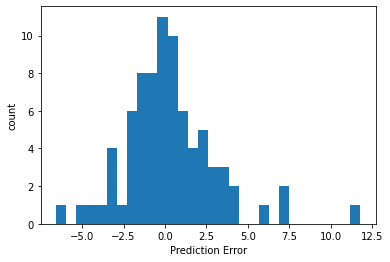

In [62]:
# Error distribution
error=y_test - y_test_pred
plt.hist(error, bins=30)
plt.xlabel('Prediction Error')
_=plt.ylabel('count')